In [1]:
import os
import torch
import torch.nn as nn


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # 平铺为行向量
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def predict(self, x):
        with torch.no_grad():
            x = self.forward(x)
            return torch.argmax(x, 1)


os.environ['WANDB_NOTEBOOK_NAME'] = '9.实验-手写数字识别实验.ipynb'

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random

# 设置全局随机种子
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)


def worker_init_fn(worker_id):
    np.random.seed(seed + worker_id)
    random.seed(seed + worker_id)


transform = transforms.Compose([
    transforms.RandomRotation(12),  # 随机旋转 12 度
    transforms.ToTensor()
])

# 加载训练数据集
train_dataset = datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)


# 定义训练数据加载器
train_loader = DataLoader(
    dataset=train_dataset, batch_size=64, shuffle=True, worker_init_fn=worker_init_fn)

In [5]:
import wandb

wandb.require("core")

model = Net()
epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

wandb_init_args = {
    'project': 'MNIST-手写数字识别',
    'config': {
        "learning_rate": learning_rate,
        "architecture": "ANN",
        "dataset": "MNIST",
        "epochs": epochs,
    },
    # 'mode': 'offline',
    'reinit': True
}
run = wandb.init(**wandb_init_args, job_type="training")
wandb_init_args['name'] = run.name
wandb.watch(model, log="all")

for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        loss.backward()
        optimizer.step()
        if (i + 1) % 100 == 0:
            wandb.log({"loss": loss.item(), "acc": acc.item()})
            print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f'
                  % (epoch + 1, epochs, i + 1, len(train_dataset) // 64, loss.item()))

wandb.finish()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /Users/wuhonglei1/.netrc


Epoch [1/10], Iter [100/937] Loss: 0.4516
Epoch [1/10], Iter [200/937] Loss: 0.4657
Epoch [1/10], Iter [300/937] Loss: 0.4818
Epoch [1/10], Iter [400/937] Loss: 0.2874
Epoch [1/10], Iter [500/937] Loss: 0.2593
Epoch [1/10], Iter [600/937] Loss: 0.2482
Epoch [1/10], Iter [700/937] Loss: 0.1383
Epoch [1/10], Iter [800/937] Loss: 0.1910
Epoch [1/10], Iter [900/937] Loss: 0.1141
Epoch [2/10], Iter [100/937] Loss: 0.2351
Epoch [2/10], Iter [200/937] Loss: 0.3916
Epoch [2/10], Iter [300/937] Loss: 0.0967
Epoch [2/10], Iter [400/937] Loss: 0.0629
Epoch [2/10], Iter [500/937] Loss: 0.0801
Epoch [2/10], Iter [600/937] Loss: 0.1345
Epoch [2/10], Iter [700/937] Loss: 0.0519
Epoch [2/10], Iter [800/937] Loss: 0.2404
Epoch [2/10], Iter [900/937] Loss: 0.2005
Epoch [3/10], Iter [100/937] Loss: 0.1781
Epoch [3/10], Iter [200/937] Loss: 0.0832
Epoch [3/10], Iter [300/937] Loss: 0.0699
Epoch [3/10], Iter [400/937] Loss: 0.1359
Epoch [3/10], Iter [500/937] Loss: 0.1676
Epoch [3/10], Iter [600/937] Loss:

acc,▁▁▅█▅██▅██
loss,█▇▂▂▄▁▁▂▁▁
acc,1
loss,0.01584


In [3]:
# 保存后加载模型
torch.save(model.state_dict(), './model.pth')

# model = Net()
# model.load_state_dict(torch.load('./server/model.pth'))

# # 创建一个示例输入张量（假设输入尺寸是 [1, 784]）
# dummy_input = torch.randn(1, 28 * 28)

# # 导出模型到 ONNX 格式
# torch.onnx.export(
#     model,                # 要转换的模型
#     dummy_input,          # 示例输入张量
#     "model.onnx",         # 导出的 ONNX 文件名
#     input_names=['input'],  # 输入张量的名称
#     output_names=['output'],  # 输出张量的名称
#     opset_version=11      # ONNX opset 版本，通常使用最新版本（这里使用 11）
# )

<All keys matched successfully>

{0: 6, 1: 1, 2: 27, 3: 22, 4: 15, 5: 25, 6: 6, 7: 13, 8: 18, 9: 31}
error-count: 164
Accuracy of the network on the 10000 test images: 98.36%


test_accuracy,█▇▆▆▆▃▆▇▅▇█▆▆█▇▆▆▇██▁▇█▂█████▇▇▇█▇█▇█▇▃▇
test_loss,▂▄▂▂▃█▅▃▁▄▃▂▂▂▄▄▂▃▁▁▁▂▃▁▂▁▁▂▁▂▁▁▁▃▂▃▁▂█▂
test_accuracy,0.9836
test_loss,0.05529


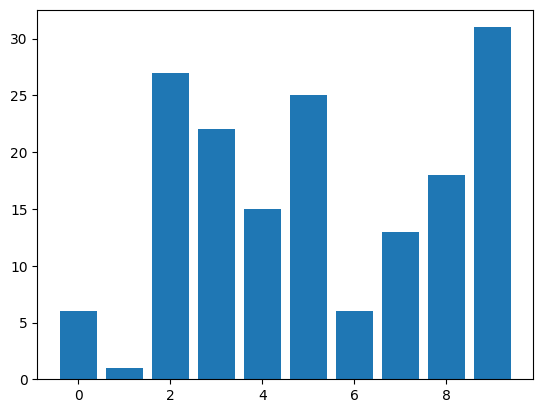

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

wandb.init(**wandb_init_args, job_type="eval")

# 加载测试数据集
test_dataset = datasets.MNIST(
    root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(
    dataset=test_dataset, batch_size=64, shuffle=False)

# 测试模型
model.eval()  # 切换到评估模式
with torch.no_grad():
    """ 统计每个数字的错误次数 """
    error_count_dict = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0,
        6: 0,
        7: 0,
        8: 0,
        9: 0
    }
    test_loss = 0.0
    correct = 0
    total = 0

    for batch_index, (images, labels) in enumerate(test_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        error_index = np.where((predicted == labels).numpy() == False)[0]
        wandb.log({
            "test_loss": loss.item(),
            "test_accuracy": (predicted == labels).float().mean().item()
        })
        for index in error_index:
            error_count_dict[labels[index].item()] += 1
            # img = images[index].squeeze().numpy() * 255
            # img = Image.fromarray(img.astype('uint8'))
            # img_dir = os.path.join(f'./misclassified_images/{labels[index]}')
            # if not os.path.exists(img_dir):
            #   os.makedirs(img_dir)
            # img.save(os.path.join(
            #     img_dir, f'{predicted[index]}_batch{batch_index}_index{index}.png'))

test_loss /= total
test_accuracy = correct / total

pprint(error_count_dict)
print('error-count:', sum(error_count_dict.values()))
print('Accuracy of the network on the 10000 test images: {:.2f}%'.format(
    100 * test_accuracy))

# 将每个数字的错误次数绘制为柱状图
plt.bar(error_count_dict.keys(), error_count_dict.values())

# 将 dict error_count_dict 的 value 由 int 转为 str
error_count_dict = {str(k): str(v) for k, v in error_count_dict.items()}

# 准备柱状图数据
data = [[digit, count] for digit, count in error_count_dict.items()]

# 创建柱状图
table = wandb.Table(data=data, columns=["Digit", "Count"])
bar_plot = wandb.plot.bar(table, "Digit", "Count",
                          title="Digit Error Distribution")

wandb.log({
    "test_loss": test_loss,
    "test_accuracy": test_accuracy,
    "digit_error_distribution": bar_plot
})

wandb.finish()